<a href="https://colab.research.google.com/github/mke27/ECON3916-Statistical-Machine-Learning/blob/main/Assignment1/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Econ 3916 Assignment 1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'Spotify', 'Price_2016': 9.99, 'Price_2024': 11.99}
]

In [4]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Spotify: 20.02% Inflation


In [5]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
chipotle = fred.get_series('CUSR0000SEFV')
spotify = fred.get_series('CUSR0000SERA02')

In [6]:
for item in student_basket:
  item['Re-Indexed'] = item['Price_2024'] / item['Price_2016'] * 100
print(student_basket)

[{'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000, 'Re-Indexed': 128.88888888888889}, {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800, 'Re-Indexed': 150.0}, {'Item': 'Chipotle Burrito', 'Price_2016': 7.5, 'Price_2024': 11.5, 'Re-Indexed': 153.33333333333334}, {'Item': 'Spotify', 'Price_2016': 9.99, 'Price_2024': 11.99, 'Re-Indexed': 120.02002002002001}]


In [7]:
def reindex_series(series, start_year=2016):
    series = series[series.index.year >= start_year]
    base_value = series.iloc[0]
    return series / base_value * 100

cpi_new = reindex_series(official_cpi)
tuition_new = reindex_series(tuition)
rent_new = reindex_series(rent)
chipotle_new = reindex_series(chipotle)
spotify_new = reindex_series(spotify)

In [8]:
years = [2016, 2024]

student = {
    item['Item']: [100, item['Re-Indexed']]
    for item in student_basket
}

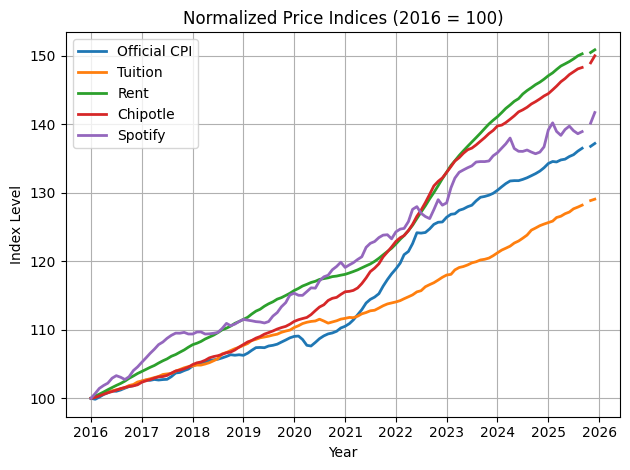

In [9]:
#plt.figure(figsize=(12, 7))

plt.plot(cpi_new.index, cpi_new, label='Official CPI', linewidth=2)
plt.plot(tuition_new.index, tuition_new, label='Tuition', linewidth=2)
plt.plot(rent_new.index, rent_new, label='Rent', linewidth=2)
plt.plot(chipotle_new.index, chipotle_new, label='Chipotle', linewidth=2)
plt.plot(spotify_new.index, spotify_new, label='Spotify', linewidth=2)

plt.title('Normalized Price Indices (2016 = 100)')
plt.xlabel('Year')
plt.ylabel('Index Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
df = pd.DataFrame({
    'Official_CPI': cpi_new,
    'Tuition': tuition_new,
    'Rent': rent_new,
    'Chipotle': chipotle_new,
    'Spotify': spotify_new
})

weights = {
    'Tuition': 0.4,
    'Rent': 0.3,
    'Chipotle': 0.1,
    'Spotify': 0.2
}

df['Student_SPI'] = (
    weights['Tuition'] * df['Tuition'] +
    weights['Rent'] * df['Rent'] +
    weights['Chipotle'] * df['Chipotle'] +
    weights['Spotify'] * df['Spotify']
)

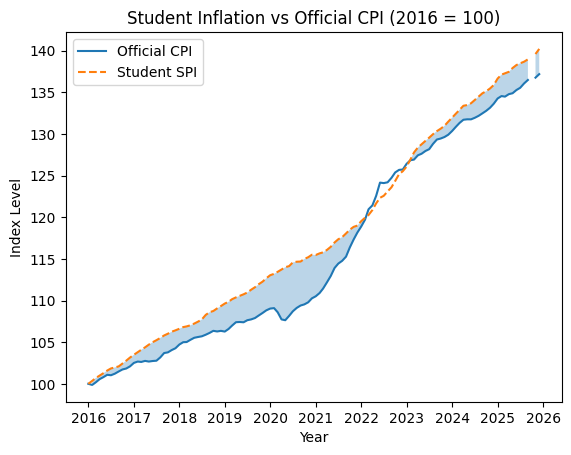

In [11]:
plt.plot(df.index, df['Official_CPI'], label='Official CPI')
plt.plot(df.index, df['Student_SPI'], label='Student SPI', linestyle='--')

plt.fill_between(
    df.index,
    df['Official_CPI'],
    df['Student_SPI'],
    where=df['Student_SPI'] > df['Official_CPI'],
    alpha=0.3
)

plt.title('Student Inflation vs Official CPI (2016 = 100)')
plt.xlabel('Year')
plt.ylabel('Index Level')
plt.legend()
plt.show()

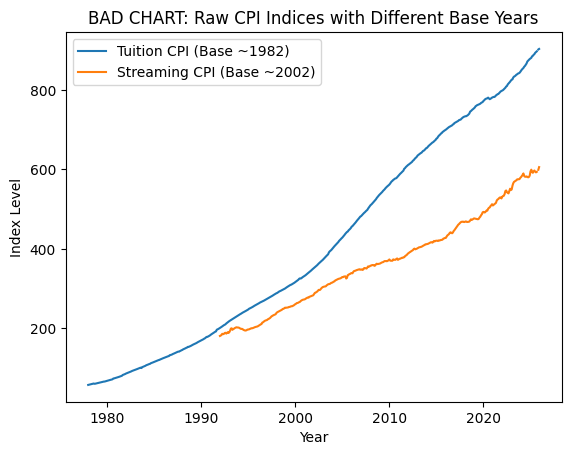

In [12]:
# "bad plot"

plt.plot(tuition.index, tuition, label='Tuition CPI (Base ~1982)')
plt.plot(spotify.index, spotify, label='Streaming CPI (Base ~2002)')

plt.title('BAD CHART: Raw CPI Indices with Different Base Years')
plt.xlabel('Year')
plt.ylabel('Index Level')
plt.legend()
plt.show()

**Explanation**
This chart is misleading because it compares CPI index levels that use different base years. This results in random starting values and give the actual values little meaning. Having a value of 900 and a value of 100 doesn't mean that prices are 9 times larger, it is just an effect of having different base years. In the "bad plot", Tuition appears too large while Streaming appears too small, even though their growth over time should be pretty similar.

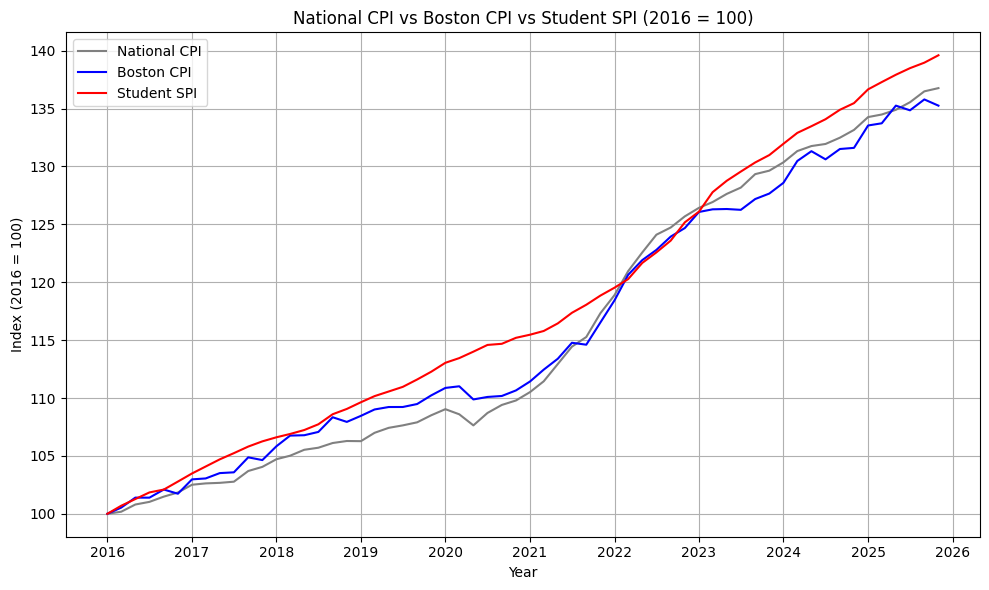

In [13]:
# ——————— Fetch Series ———————
boston_cpi = fred.get_series('CUURA103SA0')
national_cpi = fred.get_series('CPIAUCSL')

boston_idx = reindex_series(boston_cpi)
national_idx = reindex_series(national_cpi)

# ——————— Combine with existing df ———————
df['Boston_CPI'] = boston_idx
df['National_CPI'] = national_idx  # If not already in National_CPI

# Drop any rows with missing data (e.g., Boston might be bimonthly)
df = df.dropna(subset=['Boston_CPI', 'National_CPI', 'Student_SPI'])

# ——————— Plot ———————
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['National_CPI'], color='gray', label='National CPI')
plt.plot(df.index, df['Boston_CPI'], color='blue', label='Boston CPI')
plt.plot(df.index, df['Student_SPI'], color='red', label='Student SPI')

plt.title('National CPI vs Boston CPI vs Student SPI (2016 = 100)')
plt.xlabel('Year')
plt.ylabel('Index (2016 = 100)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()